In [12]:
import numpy as np
import torch as th
import glob, os
import matplotlib.pyplot as plt
from PIL import Image
import torchvision

def sort_by_frame(path_list):
    frame_anno = []
    for p in path_list:
        frame_idx = os.path.splitext(p.split('/')[-1].split('_')[-1])[0][5:]   # 0-4 is "frame", so we used [5:] here
        frame_anno.append(int(frame_idx))
    sorted_idx = np.argsort(frame_anno)
    sorted_path_list = []
    for idx in sorted_idx:
      sorted_path_list.append(path_list[idx])
    return sorted_path_list

path = '/data/mint/sampling/TPAMI/cast_shadows_results/log=DiFaReli_FsBg_Sdiff_SS_128_VLL_cfg=DiFaReli_FsBg_Sdiff_SS_128_VLL.yaml_inv_with_sd_rotateSH_axis2_SSdat/ema_100000/valid/render_face/reverse_sampling/src=66376.jpg/dst=60000.jpg/Lerp_1000/n_frames=60'
sd = sort_by_frame(glob.glob(path + '/shadm_shad_frame*.png'))

sd_img = [th.tensor(np.array(Image.open(p))) for p in sd]
sd_img = th.stack(sd_img, dim=0)
sd_img = th.cat((sd_img, th.flip(sd_img, dims=[0])), dim=0)

torchvision.io.write_video('shadm_shad.mp4', sd_img, 20)


(512, 512, 1) (512, 512, 1) (512, 512, 1) (512, 512, 1)


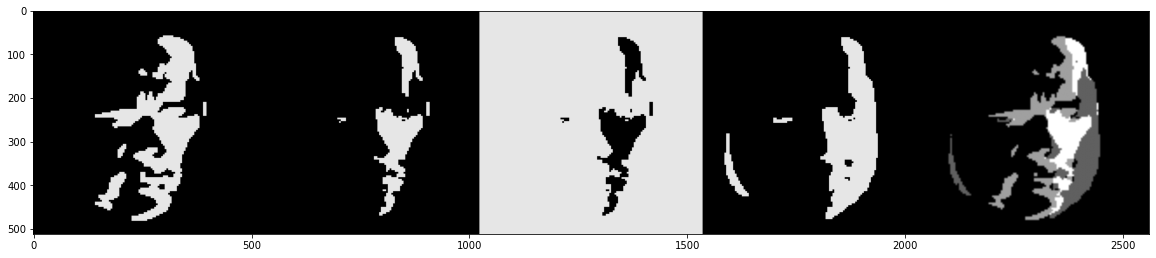

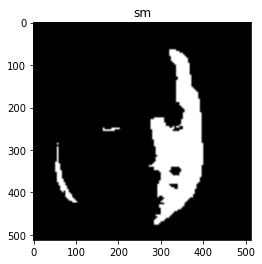

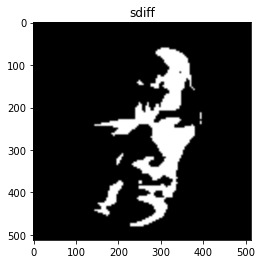

2
[#] Length of out[sm]: 20
(20, 512, 512, 3)
[#] Length of out[sdiff]: 12
(12, 512, 512, 3)
(13, 512, 512, 3)


In [13]:
# Erosion
from scipy import ndimage
import cv2

sd_img = [(np.array(Image.open(p)))/255. for p in sd]
sdiff = sd_img[0][..., 0:1]
sm = sd_img[1][..., 0:1]
rs = 512
sdiff = cv2.resize(sdiff, (rs, rs))[..., None]
sm = cv2.resize(sm, (rs, rs))[..., None]
# sdiff = sdiff.resize(sdiff, (512, 512))
# sm = sm.resize(sm, (512, 512))

intr = np.logical_and(sdiff, sm)
overlay = cv2.addWeighted(sdiff, 1, sm, 0.6, 0)[..., None]

print(sdiff.shape, sm.shape, intr.shape, overlay.shape)
fig = plt.figure(figsize=(20, 20))
plt.imshow(np.concatenate((sdiff > 0, intr, ~intr, sm > 0, overlay), axis=1), cmap='gray')
plt.show()


proc_set = {'sm':sm, 'sdiff':sdiff}
out = {'sm': [sm], 'sdiff': [sdiff]}

for k in proc_set.keys():
    # tmp = ((proc_set[k] > 0.) * 1).copy()
    tmp = proc_set[k].copy()
    plt.imshow(tmp, cmap='gray')
    plt.title(k)
    plt.show()
    count = 0
    erosion_size = 2
    element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2 * erosion_size + 1, 2 * erosion_size + 1),
                                (erosion_size, erosion_size))
    org = tmp.copy()
    
    
    break_cond = True
    breaking_repeated = []
    while break_cond:
        # tmp = ndimage.binary_erosion(tmp, mask=~intr, iterations=1)
        tmp = cv2.erode(tmp, kernel=element, iterations=1)  # with cv2.erode the last dim is squeezed
        tmp = tmp[..., None]
        tmp = (tmp * ~intr) + (intr * org) # Modified only the area inside intr
        
        out[k].append(tmp)
        break_cond = (np.logical_and(tmp, intr).sum() / np.logical_or(tmp, intr).sum()) < 0.99
        breaking_repeated.append(break_cond)
        if len(breaking_repeated) > 20:
            break_cond = False if np.mean(breaking_repeated[-10:]) == breaking_repeated[-1] else True

print(len(out))
# plt.figure(figsize=(120, 120))
vids = {}
for k in out.keys():
    print("[#] Length of out[{}]: {}".format(k, len(out[k])))
    vid = np.stack(out[k])
    vid = np.repeat(vid, 3, axis=-1)
    vid = vid * 255
    print(vid.shape)
    vids[k] = vid
    torchvision.io.write_video('{}.mp4'.format(k), th.tensor(vid), 20)
    
final_vid = np.concatenate([vids['sdiff'], vids['sm'][::-1, ...]], axis=0)
torchvision.io.write_video('final.mp4', th.tensor(final_vid), 20)

# subsampling the video to have the equal number of frames for both sdiff and sm (shorter one)
shorter = min(len(vids['sdiff']), len(vids['sm']))
longer = max(len(vids['sdiff']), len(vids['sm']))
idx = np.linspace(0, longer-1, shorter).astype(int)

if len(vids['sdiff']) < len(vids['sm']):
    vids['sm'] = vids['sm'][::-1, ...][idx]
else:
    vids['sdiff'] = vids['sdiff'][idx]

# union version
final_union_vid = np.logical_or(vids['sdiff'][1:], vids['sm'][:-1])
final_union_vid = np.concatenate([vids['sdiff'][0:1] > 0, final_union_vid, vids['sm'][-1:] > 0], axis=0)
print(final_union_vid.shape)
# keep the first and last frame stay a bit longer
final_union_vid = np.concatenate([np.repeat(final_union_vid[0:1], repeats=5, axis=0), final_union_vid, np.repeat(final_union_vid[-1:], repeats=5, axis=0)], axis=0)
sdiff = np.repeat(sdiff, repeats=3, axis=-1) > 0
sm = np.repeat(sm, repeats=3, axis=-1) > 0
final_union_vid = np.concatenate([np.repeat(sdiff[None, ...], repeats=final_union_vid.shape[0], axis=0), final_union_vid, np.repeat(sm[None, ...], repeats=final_union_vid.shape[0], axis=0)], axis=2)
    
torchvision.io.write_video('final_union.mp4', th.tensor(final_union_vid)*255, 15)


ValueError: Unsupported dtype

<Figure size 432x288 with 1 Axes>

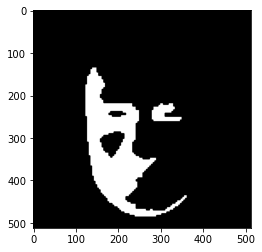

In [4]:
plt.imshow(sm>0, cmap='gray')
plt.show()

# plt.imshow(cv2.erode(sm))
plt.imshow(ndimage.binary_erosion((sm[..., 0] > 0).astype(int)), cmap='gray')
plt.show()